In [15]:
import numpy as np
from scipy.linalg import norm, inv, sqrtm, svd 

import matplotlib.pyplot as plt
import matplotlib as mpl



from src.data_driven import Plant, BiasSignal

from src.constants import (As, Bs) # system model
from src.constants import (SIM_TIME, SIM_INIT_STATE_RANGE, 
                       THRESHOLD, T_INJECTION, BETA)


In [16]:
def print_experiment_parameters():
    """
    Prints the system and experiment parameters.
    """
    print(f"Simulation time: {SIM_TIME}")
    print(f"Initial state range for simulation: {SIM_INIT_STATE_RANGE}")
    print(f"Threshold parameter: {THRESHOLD}")
    print(f"Time of signal injection: {T_INJECTION}")
    print(f"Beta constant in the added signal: {BETA}")



# System and experiment parameters
print_experiment_parameters()   




Simulation time: 30
Initial state range for simulation: 0.1
Threshold parameter: 0.2
Time of signal injection: 10
Beta constant in the added signal: 0.5


In [17]:
# initializing plant   
plant = Plant(As, Bs)

n = plant.num_states # number of states
m = plant.num_inputs # number of inputs

In [18]:
data_path = "clean_data_epsilon_bar.npz"

try:
    loaded_data = np.load(data_path)
    print("Loaded the nominal data successfully")
except:
    print("""First we run the nominal case 
          since the data was not available""")
    %run ./privacy_for_nominal_system.ipynb
    loaded_data = np.load(data_path)   

F1 = loaded_data["F1"]
G1 = loaded_data["G1"]
K_bar = loaded_data["K_bar"]
eps_bar = loaded_data["eps_bar"]
key_range = loaded_data["key_range"]



Loaded the nominal data successfully


In [19]:


F2, G2 = plant.post_processing_controller(F1, G1, eps_bar,
                                                  key_range, Bs)
K_star = F2 + (np.eye(m) + G2) @ K_bar

x0 = plant.random_matrix(n, 1, SIM_INIT_STATE_RANGE) # random initial state


In [20]:

res_diff_biases = {} # place holder for  results 

# initializing the class
bias_sig = BiasSignal(As, Bs, F1, G1, F2, G2, K_bar, THRESHOLD)

ad_infos = ['no_bias', 'perfect_info', 'use_of_estimation', 'know_Bcl',
                   'know_norm_of_Bcl'] # different policies for generating bias signal



for ad_info in ad_infos:
    ainf = bias_sig.a_inf(ad_info)

    X = plant.get_traject_bias(K_star, x0, SIM_TIME, T_INJECTION, BETA, ainf)
    res_diff_biases[ad_info] = np.sqrt(sum(X**2)).reshape(-1, 1) # energy for the states




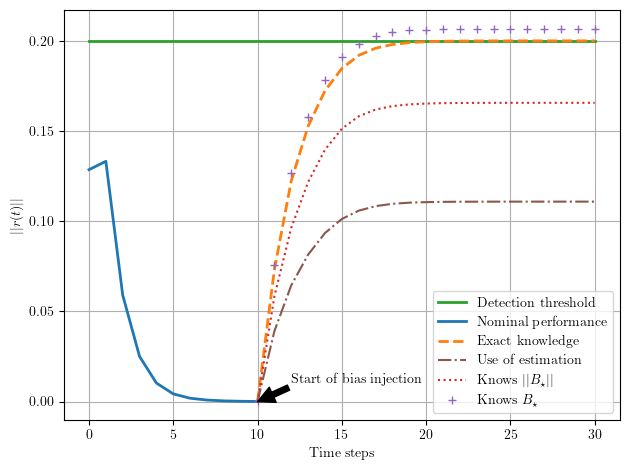

In [21]:
# plotting the results

time_steps = np.arange(SIM_TIME+1).reshape(-1, 1) # time steps for plotting the results
threshold_steps = THRESHOLD * np.ones((SIM_TIME+1, 1)) # threshold for detecting bias injection




mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')


fig = plt.figure()
ax = fig.subplots(1,1)


ax.plot(time_steps, threshold_steps, lw=2, label ='Detection threshold', c='tab:green')

ax.plot(time_steps[:T_INJECTION+1], res_diff_biases['no_bias'][:T_INJECTION+1],
         lw=2, label="Nominal performance", c='tab:blue')

ax.plot(time_steps[T_INJECTION:], res_diff_biases['perfect_info'][T_INJECTION:], 
          '--', lw=2, label="Exact knowledge", c='tab:orange' )

ax.plot(time_steps[T_INJECTION:], res_diff_biases['use_of_estimation'][T_INJECTION:],
         '-.',label="Use of estimation", c='tab:brown')

ax.plot(time_steps[T_INJECTION:], res_diff_biases['know_norm_of_Bcl'][T_INJECTION:], 
        ':',label= r" Knows $||B_{\star}||$", c='tab:red')

ax.plot(time_steps[T_INJECTION:], res_diff_biases['know_Bcl'][T_INJECTION:],
         '+',label= r" Knows $B_{\star}$", c='tab:purple')



ax.grid()
ax.legend(loc='lower right')
ax.set_ylabel(r"$||r(t)||$")
ax.set_xlabel("Time steps")
ax.annotate('Start of bias injection',xy=(T_INJECTION, 0), xytext=(T_INJECTION+2, 0.01),
             arrowprops=dict(facecolor='black', shrink=0))
plt.tight_layout()
plt.show()
fig.savefig("bias_injection.pdf", transparent=True)


